In [130]:
from __future__ import division, print_function
import sys
import os
import json
import sys
import csv
import pandas as pd
import numpy as np
import pylab as py
from pandas import Series, DataFrame
%pylab inline
#import seaborn
from scipy.optimize import curve_fit, minimize

Populating the interactive namespace from numpy and matplotlib


In [131]:
if os.getenv ('PUI2016') is None:
    print ("Must set env variable PUI2016")
print (os.getenv ('PUI2016'))
print (os.getenv ('PUIDATA'))

/home/cusp/rav220/PUI2016
/home/cusp/rav220/PUIdata


In [132]:
print (os.getenv ('PUI2016')+'/fbb_matplotlibrc.json')

/home/cusp/rav220/PUI2016/fbb_matplotlibrc.json


In [133]:
### A function to download the data: simple bash commands can be run by preceding them with !
### but more complex command lines with variable arguments need to be build as strng and run with os.system


def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
                os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")
        
print('ok?')

ok?


In [134]:
datestring = '201402'
getCitiBikeCSV(datestring)


file in place, you can continue


In [135]:
df=pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')
# df is the dataframe where the content of the csv file is stored
df['date'] = pd.to_datetime(df['starttime'])
# note that with dataframes I can refer to variables as dictionary keys, 
# i.e. df['starttime'] or as attributes: df.starttime. 
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date
0,382,2014-02-01 00:00:00,2014-02-01 00:06:22,294,Washington Square E,40.730494,-73.995721,265,Stanton St & Chrystie St,40.722293,-73.991475,21101,Subscriber,1991,1,2014-02-01 00:00:00
1,372,2014-02-01 00:00:03,2014-02-01 00:06:15,285,Broadway & E 14 St,40.734546,-73.990741,439,E 4 St & 2 Ave,40.726281,-73.989780,15456,Subscriber,1979,2,2014-02-01 00:00:03
2,591,2014-02-01 00:00:09,2014-02-01 00:10:00,247,Perry St & Bleecker St,40.735354,-74.004831,251,Mott St & Prince St,40.723180,-73.994800,16281,Subscriber,1948,2,2014-02-01 00:00:09
3,583,2014-02-01 00:00:32,2014-02-01 00:10:15,357,E 11 St & Broadway,40.732618,-73.991580,284,Greenwich Ave & 8 Ave,40.739017,-74.002638,17400,Subscriber,1981,1,2014-02-01 00:00:32
4,223,2014-02-01 00:00:41,2014-02-01 00:04:24,401,Allen St & Rivington St,40.720196,-73.989978,439,E 4 St & 2 Ave,40.726281,-73.989780,19341,Subscriber,1990,1,2014-02-01 00:00:41


In [136]:
df.columns

Index([u'tripduration', u'starttime', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender', u'date'],
      dtype='object')

In [137]:
df.drop(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid',
       'birth year', 'gender'], axis=1, inplace=True)

In [138]:
df.columns

Index([u'usertype', u'date'], dtype='object')

In [139]:
df.usertype.value_counts()

Subscriber    218019
Customer        6717
Name: usertype, dtype: int64

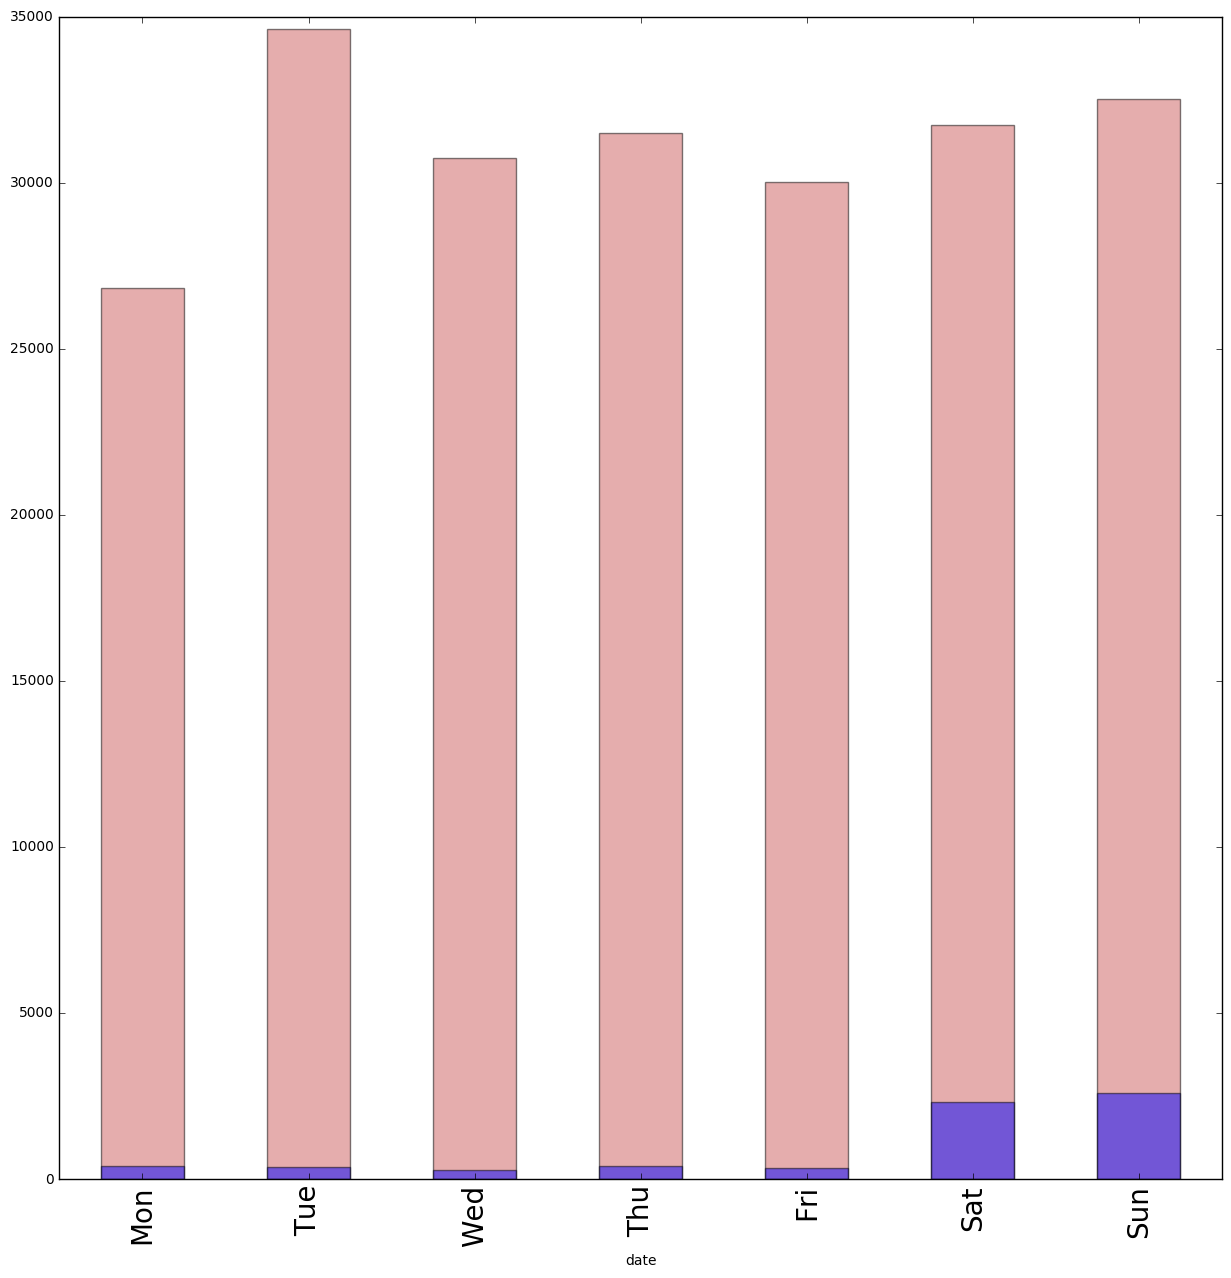

In [140]:
fig=pl.figure(figsize(15,15))

#instad of plotting with matplotlib i.e. plot() i use the plot method in pandas
norm_s = 1
ax = ((df['date'][df['usertype'] == 'Subscriber'].groupby([df['date'].dt.weekday]).count()) / norm_s).plot(kind="bar", 
                                                                                         color='IndianRed', 
                                                                                         alpha=0.5)
norm_c = 1
ax = ((df['date'][df['usertype'] == 'Customer'].groupby([df['date'].dt.weekday]).count()) / norm_c).plot(kind="bar", 
                                                                                              alpha=0.5)

tmp = ax.xaxis.set_ticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], fontsize=20)

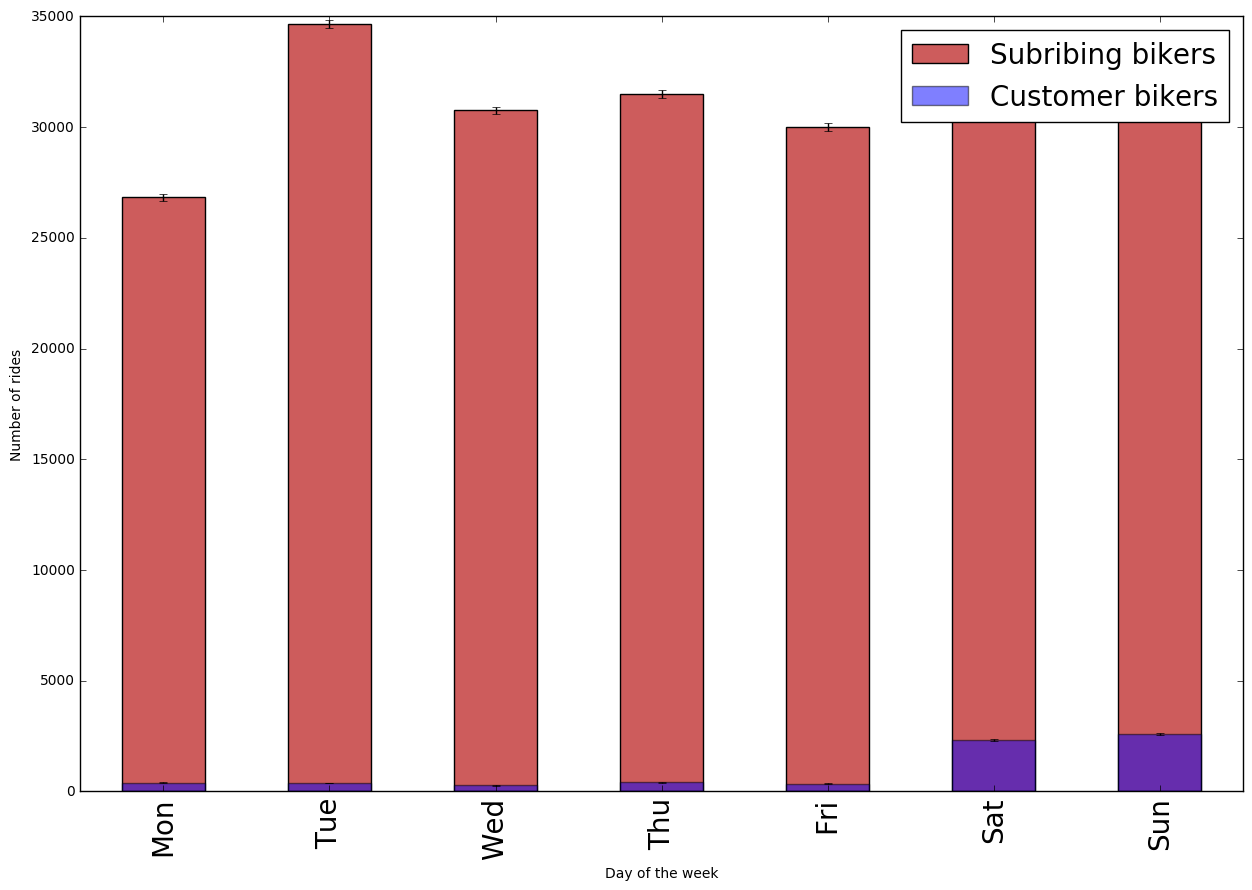

In [141]:
fig=pl.figure(figsize(15,10))

counts_s = df.date[df.usertype == 'Subscriber'].groupby([df.date.dt.weekday]).count()
norm_s = 1
error_s = np.sqrt(counts_s)
ax=((counts_s) / norm_s).plot(kind="bar",color='IndianRed',  yerr=[
            ((error_s) / norm_s, (error_s) / norm_s)], label='Subscribing bikers')


counts_c = df.date[df.usertype == 'Customer'].groupby([df.date.dt.weekday]).count()
norm_c = 1
error_c=np.sqrt(counts_c)
((counts_c) / norm_c).plot(kind="bar", alpha=0.5, yerr=[((error_c) / norm_c, (error_c) / norm_c)], label='Customer bikers')
ax.xaxis.set_ticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], fontsize=20)
ax.set_ylabel ("Number of rides")
ax.set_xlabel ("Day of the week")
pl.legend(['Subribing bikers','Customer bikers'],fontsize=20)

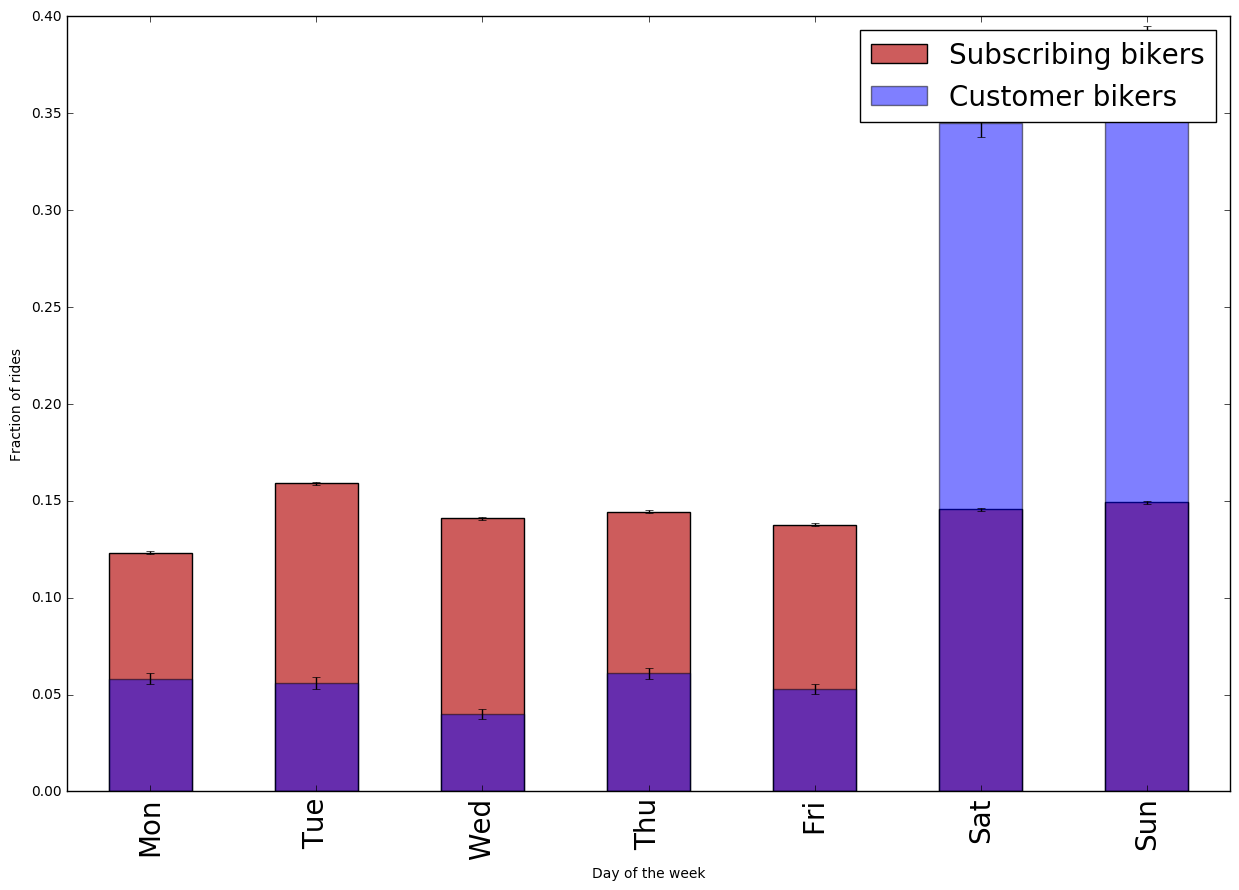

In [142]:
fig = pl.figure(figsize(15,10))

norm_s = counts_s.sum()
error_s = np.sqrt(counts_s)
((counts_s) / norm_s).plot(kind="bar",color='IndianRed',  yerr=[
            ((error_s) / norm_s, (error_s) / norm_s)], label='Subscribing bikers')

norm_c = counts_c.sum()
ax = ((counts_c) / norm_c).plot(kind="bar", alpha=0.5, yerr=[((error_c)/norm_c,(error_c)/norm_c)], label='Customer bikers')
ax.xaxis.set_ticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], fontsize=20)
ax.set_ylabel ("Fraction of rides")
ax.set_xlabel ("Day of the week")

pl.legend(['Subscribing bikers','Customer bikers'],fontsize=20)

Customers: week:0.268, weekend:0.732, weekend error:0.006, weekend error:0.010
Subscribers: week:0.705, weekend:0.295, weekend error:0.002, weekend error:0.001


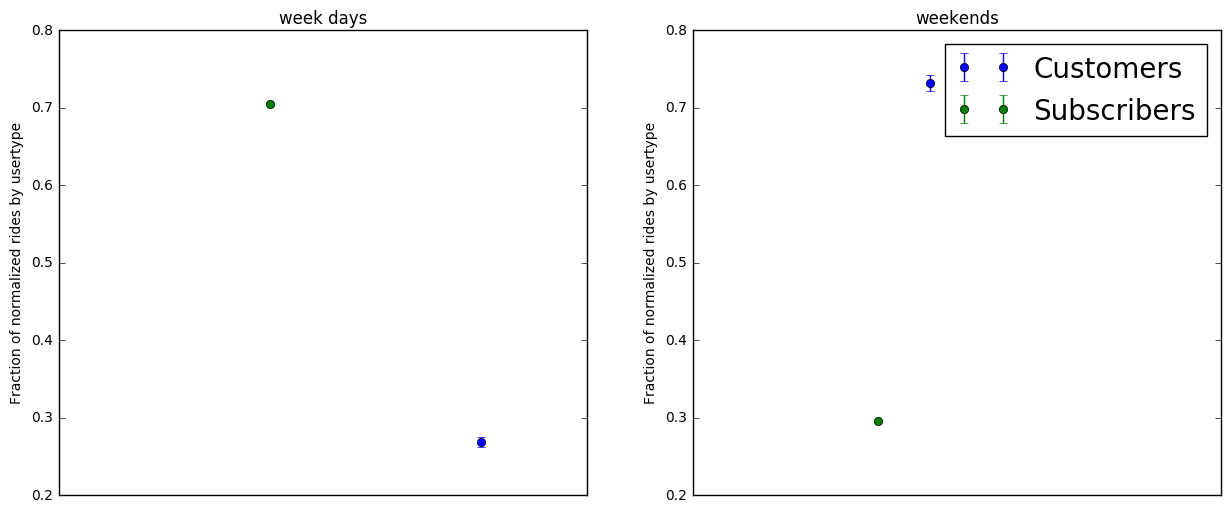

In [143]:
fig = pl.figure(figsize(15,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_xticks([])
ax2.set_xticks([])
week_s = sum(counts_s[:-2]) * 1.0 / norm_s
weekend_s = sum(counts_s[-2:]) * 1.0 / norm_s
eweek_s = np.sqrt(sum(error_s[:-2]**2)) / norm_s
eweekend_s = np.sqrt(sum(error_s[-2:]**2)) / norm_s

week_c = sum(counts_c[:-2]) * 1.0 / norm_c
weekend_c = sum(counts_c[-2:]) * 1.0 / norm_c
eweek_c = np.sqrt(sum(error_c[:-2]**2)) / norm_c
eweekend_c = np.sqrt(sum(error_c[-2:]**2)) / norm_c

print("Customers: week:{0:.3f}, weekend:{1:.3f}, weekend error:{2:.3f}, weekend error:{3:.3f}"\
      .format(week_c, weekend_c, eweek_c, eweekend_c))
print("Subscribers: week:{0:.3f}, weekend:{1:.3f}, weekend error:{2:.3f}, weekend error:{3:.3f}"\
      .format(week_s, weekend_s, eweek_s, eweekend_s))

ax1.errorbar([0.4], [week_c], yerr=[eweek_c], fmt='o', label='Customers')
ax1.errorbar([0.2], [week_s], yerr=[eweek_s], fmt='o', label='Subscribers')
ax1.set_xlim(0, 0.5)
ax2.errorbar([0.4], [weekend_c], yerr=[eweekend_c], fmt='o', label='Customers')
ax2.errorbar([0.2], [weekend_s], yerr=[eweekend_s], fmt='o', label='Subscribers')
ax1.set_xlim(0, 0.5)
ax1.set_title("week days")
ax2.set_title("weekends")
ax2.set_ylabel("Fraction of normalized rides by usertype")
ax1.set_ylabel("Fraction of normalized rides by usertype")

pl.xlim(-0.5, 1.5)
pl.legend(fontsize = 20)